# Set up environment

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import copy
import shutil
from PIL import Image
from tqdm.autonotebook import tqdm
import sys
import xml.etree.cElementTree as ET

## Import utility functions from Pytorch

In [2]:
ROOT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))

sys.path.append(os.path.join(ROOT_DIR, "utilities"))

from engine import train_one_epoch, evaluate
import utils

## Enable GPU

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", device)

Running on cuda:0


## Declare parameters

In [4]:
IMAGE_SIZE = 512
BATCH_SIZE = 1

# Input data

## Download Food256 dataset

To extend the food classification into food detection I will need a dataset that includes bounding boxes, thus I have used food-256 including 256 different classes that contain atleast 100 images each. If the given directory not found then dataset is downloaded and extracted.

In [5]:
FOOD256_DIR = os.path.join(os.path.abspath(os.sep), "Datasets", "food256")

if not os.path.exists(FOOD256_DIR):
  print("Downloading Food-256 dataset... ", end="")
  !wget http://foodcam.mobi/dataset256.zip
  print("Done")


  print("Extracting data... ", end="")
  !unzip dataset256.zip
  print("Done")

## Format dataset in VOC Format

Please refer to format_voc notebook in utilities directory.

## Define FoodDataset class

In the condensed version we read a list of condensed classes in the current working directory and only include images containing such catergories.

In [6]:
class FoodDataset(torch.utils.data.Dataset):
    def __init__(self, root, images, transform=None):
        self.root = root
        self.transform = transform
        self.classes = self.getClasses()
        self.images = self.condense(images)
            
            
    def getClasses(self):
        classes = []
        with open("condensed_category.txt", 'r') as file:
            file.readline()
            for line in file.readlines():
                classes.append(line.strip().split("\t")[1])
        return classes
            
        
    def condense(self, images):
        condensed = []
        
        for img in images:
            # open annotations file
            tree = ET.parse(os.path.join(self.root, "Annotations", img.replace('.jpg', '.xml')))
            root = tree.getroot()
                            
            # add to condensed only if contains class in condensed classed
            for obj in root.findall('object'):
                class_name = obj.find('name').text
                if class_name in self.classes:
                    condensed.append(img)
                    break
                            
        return condensed
            
                
    def getLabels(self, img_id):
        # open annotations file
        tree = ET.parse(os.path.join(self.root, "Annotations", img_id+'.xml'))
        root = tree.getroot()
        
        boxes = []
        areas = []
        labels = []
    
        # read bounding boxes
        for obj in root.findall('object'):
            class_name = obj.find('name').text
            
            if class_name in self.classes:
                # get bounding box
                box = obj.find('bndbox')
                x1 = float(box.find('xmin').text)
                y1 = float(box.find('ymin').text)
                x2 = float(box.find('xmax').text)
                y2 = float(box.find('ymax').text)

                boxes.append([x1, y1, x2, y2])
                areas.append((x2-x1)*(y2-y1))
                labels.append(self.classes.index(class_name))
        
        return boxes, areas, labels

        
    def __getitem__(self, index):
        # image
        img_path = os.path.join(self.root, "JPEGImages", self.images[index])
        img = Image.open(img_path).convert("RGB")
        
        # annotations
        boxes, areas, labels = self.getLabels(self.images[index].split('.')[0])

        target = {
            "image_id": torch.as_tensor([index]),
            "labels": torch.as_tensor(labels, dtype=torch.int64),
            "boxes": torch.as_tensor(boxes, dtype=torch.float32),
            "area": torch.as_tensor(areas),
            "iscrowd": torch.zeros((len(labels)), dtype=torch.int64)
        }
        
        if self.transform is not None:
            img, target = self.transform(img, target)
            
        return img, target
        
    
    def __len__(self):
        return len(self.images)

## Format images for model input

In [7]:
# custom transform for R-CNN input
class CustomTransform:
    def __init__(self, image_size):
        self.image_size = image_size
        
    def __call__(self, img, target):
        # resize to a max of IMAGE_SIZE
        w, h = img.size
        scale = min(IMAGE_SIZE/w, IMAGE_SIZE/h)
        img = transforms.functional.resize(img, (int(h*scale), int(w*scale)))
        
        
        # update bounding boxes
        target["boxes"] *= scale
        
        # update areas
        target["area"] *= scale**2
        
        # add padding to a size of IMAGE_SIZE
        img = transforms.functional.pad(img, (0, 0, IMAGE_SIZE-int(w*scale), IMAGE_SIZE-int(h*scale)))
        
        # convert to tensor
        img = transforms.functional.to_tensor(img)

        # normalize
        img = transforms.functional.normalize(img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        return img, target

transform = CustomTransform(image_size=IMAGE_SIZE)

## Read training and validations splits

In [8]:
SPLIT_DIR = os.path.join(FOOD256_DIR, "ImageSets", "Main")

with open(os.path.join(SPLIT_DIR, "train.txt"), 'r') as file:
    images = [x.strip() for x in file.readlines()]
    train_raw = FoodDataset(FOOD256_DIR, images, transform=transform)
    
with open(os.path.join(SPLIT_DIR, "val.txt"), 'r') as file:
    images = [x.strip() for x in file.readlines()]
    val_raw = FoodDataset(FOOD256_DIR, images, transform=transform)

train_size = len(train_raw)
val_size = len(val_raw)

class_names = train_raw.classes

print("Number of training images: {0}".format(train_size))
print("Number of validation images: {0}".format(val_size))

Number of training images: 8361
Number of validation images: 932


## Batch datasets for training and evaluation

In [9]:
# define how to batch data (i.e not combine target dicitonaries)
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = torch.utils.data.DataLoader(train_raw, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val_raw, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

## Show example training image with bounding boxes

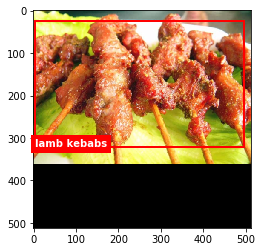

In [10]:
fig, axis= plt.subplots(1)

#randomly select image from dataset
i = np.random.randint(train_size)
img = train_raw[i][0].clone().numpy()

# unnormalize
img[0] = img[0] * 0.229
img[1] = img[1] * 0.224 
img[2] = img[2] * 0.225 
img[0] += 0.485 
img[1] += 0.456 
img[2] += 0.406

img = np.transpose(img, (1,2,0))
img = np.clip(img, 0, 1)
plt.imshow(img)

labels = train_raw[i][1]["labels"]
boxes = train_raw[i][1]["boxes"]

# draw bounding boxes
for i in range(len(labels)):
    x1, y1, x2, y2 = boxes[i]
    box = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
    axis.add_patch(box)
    axis.text(x1, y2, class_names[labels[i]], fontdict=dict(color='w', weight='bold'), bbox=dict(facecolor='r', edgecolor='none'))

fig

# Model

In order to train the food detector I will train from a pretrained Faster R-CNN model.

## Declare backbone model architecture

Currently supports:
    - mobilenet_v2
    - wide_resnet_101
    - resnet_50

In [17]:
MODEL_NAME = "mobilenet_v2"

## Fetch pretrainied backbone

In [18]:
BACKBONE_PATH = os.path.join(ROOT_DIR, "models", "condensed_food_detection", "backbones", MODEL_NAME, "fine_tuning.pt")

print("Fetching pretrained backbone model... ", end="")

if MODEL_NAME == "wide_resnet_101":
    # fetch backbone model architecture
    backbone = torchvision.models.wide_resnet101_2(pretrained=False)

    # replace classification head
    num_features = backbone.fc.in_features
    backbone.fc = torch.nn.Linear(num_features, len(class_names))

    # load trained weights
    backbone.load_state_dict(torch.load(BACKBONE_PATH))

    # remove classification head
    backbone = torch.nn.Sequential(*list(backbone.children())[:-2])
    backbone.out_channels = 2048
    
elif MODEL_NAME == "mobilenet_v2":
    # fetch backbone model architecture
    backbone = torchvision.models.mobilenet_v2(pretrained=False)
    
    # replace classification head
    num_features = backbone.classifier[1].in_features
    backbone.classifier[1] = torch.nn.Linear(num_features, len(class_names))

    # load trained weights
    backbone.load_state_dict(torch.load(BACKBONE_PATH))

    # remove classification head
    backbone = backbone.features
    backbone.out_channels = 1280

print("done")

Fetching pretrained backbone model... done


## Embed into Faster R-CNN

In [19]:
print("Creating model... ", end="")

if MODEL_NAME == "resnet_50":
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, len(class_names))
    
else:
    # encapsulate backbone within faster RCNN model
    anchor_generator = torchvision.models.detection.rpn.AnchorGenerator(sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),))
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)
    model = torchvision.models.detection.FasterRCNN(backbone, num_classes=len(class_names), rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)

model = model.to(device)
print("done")

Creating model... done


## Load checkpoint if weights file exists

In [20]:
MODEL_PATH = os.path.join(ROOT_DIR, "models", "condensed_food_detection", MODEL_NAME, "fine_tuning.pt")

if os.path.exists(MODEL_PATH):
    print("Loading weights from checkpoint...", end="")
    model.load_state_dict(torch.load(MODEL_PATH))
    print("done")

Loading weights from checkpoint...done


# Train via fine-tuning

## Declare training parameters

In [21]:
learning_rate = 0.001
epochs = 5

# fetch trainable parameters for transfer learning(where requires_grad = true)
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=learning_rate)

## Train and save model

In [22]:
for epoch in range(epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=1000)
    evaluate(model, val_loader, device)
    
    # overwrite model weights file
    torch.save(model.state_dict(), MODEL_PATH+str(epoch))

Epoch: [0]  [   0/8361]  eta: 0:28:18  lr: 0.000002  loss: 0.0367 (0.0367)  loss_classifier: 0.0270 (0.0270)  loss_box_reg: 0.0071 (0.0071)  loss_objectness: 0.0013 (0.0013)  loss_rpn_box_reg: 0.0013 (0.0013)  time: 0.2031  data: 0.0146  max mem: 1546
Epoch: [0]  [1000/8361]  eta: 0:19:44  lr: 0.001000  loss: 0.0464 (0.0590)  loss_classifier: 0.0235 (0.0314)  loss_box_reg: 0.0065 (0.0097)  loss_objectness: 0.0004 (0.0043)  loss_rpn_box_reg: 0.0086 (0.0136)  time: 0.1629  data: 0.0065  max mem: 1803
Epoch: [0]  [2000/8361]  eta: 0:17:25  lr: 0.001000  loss: 0.0560 (0.0586)  loss_classifier: 0.0325 (0.0310)  loss_box_reg: 0.0067 (0.0097)  loss_objectness: 0.0017 (0.0041)  loss_rpn_box_reg: 0.0096 (0.0138)  time: 0.1661  data: 0.0066  max mem: 1803
Epoch: [0]  [3000/8361]  eta: 0:14:51  lr: 0.001000  loss: 0.0378 (0.0594)  loss_classifier: 0.0186 (0.0313)  loss_box_reg: 0.0038 (0.0098)  loss_objectness: 0.0006 (0.0043)  loss_rpn_box_reg: 0.0064 (0.0140)  time: 0.1671  data: 0.0065  max me

Test:  [300/932]  eta: 0:00:30  model_time: 0.0368 (0.0366)  evaluator_time: 0.0010 (0.0015)  time: 0.0499  data: 0.0101  max mem: 1803
Test:  [400/932]  eta: 0:00:25  model_time: 0.0359 (0.0364)  evaluator_time: 0.0020 (0.0015)  time: 0.0481  data: 0.0096  max mem: 1803
Test:  [500/932]  eta: 0:00:21  model_time: 0.0369 (0.0364)  evaluator_time: 0.0010 (0.0015)  time: 0.0487  data: 0.0094  max mem: 1803
Test:  [600/932]  eta: 0:00:16  model_time: 0.0359 (0.0363)  evaluator_time: 0.0020 (0.0015)  time: 0.0481  data: 0.0090  max mem: 1803
Test:  [700/932]  eta: 0:00:11  model_time: 0.0359 (0.0362)  evaluator_time: 0.0020 (0.0015)  time: 0.0481  data: 0.0098  max mem: 1803
Test:  [800/932]  eta: 0:00:06  model_time: 0.0329 (0.0362)  evaluator_time: 0.0010 (0.0015)  time: 0.0466  data: 0.0095  max mem: 1803
Test:  [900/932]  eta: 0:00:01  model_time: 0.0369 (0.0361)  evaluator_time: 0.0010 (0.0015)  time: 0.0486  data: 0.0097  max mem: 1803
Test:  [931/932]  eta: 0:00:00  model_time: 0.03

KeyboardInterrupt: 